## Early Warning System for Corporate Distress

ECE 143 - Group 14

Team Members: Kendra Chen, Zhuosheng Song, Matthew Alegrado, Jinglin Cao

This notebook presents a comprehensive analysis of Company Bankruptcy Prediction in Taiwan dataset, investigating financial indicators that signal corporate distress. The objective is to construct a robust predictive pipeline capable of identifying firms at elevated risk of bankruptcy.

## 1.1 Primary Task

**Main task**: Build a model pipeline to assess company distress using financial indicators.

We propose a pipeline consisting of PCA-based feature engineering and selection, followed by VIF pruning to remove multicollinearity, then training a classification model to determine whether a company is likely to experience distress given its current business statistics. The pipeline also derives interpretable decision thresholds with SHAP analysis and monitoring rules based on influential financial indicators and visualizes model explanations.

## 1.2 Evaluation Strategy

Multiple evaluation metrics are applied to assess prediction quality and interpretability:

- **ROC-AUC**: Measures the model's ability to distinguish bankrupt from non‑bankrupt firms across all classification thresholds.

- **PR-AUC**: Evaluates precision and recall for the minority class, emphasizing correct detection of bankruptcies.

- **F1 Score**: Balances precision and recall, providing a single metric for detecting bankrupt firms.

Given the dataset's extreme class imbalance (approximately 3% bankrupt vs. 97% non‑bankrupt firms), the F1 score provides a more reliable indicator of model performance than accuracy. Models that ignore minority cases may achieve high accuracy while failing to detect distress, making F1 the metric of primary interest.

## 1.3 Baseline Approach

We define two baseline models to provide reference performance:

- Naive baseline: Predicts all companies as non-bankrupt. While this achieves high overall accuracy, it fails to detect any bankrupt firms, resulting in an F1 score of zero.

- Insight-based baseline: Select a small set of financial ratios from the literature that are historically associated with bankruptcy. This tests the predictive power of well-known indicators.

### 1.4 Validity Assessment

Model validity is established by confirming that performance on a held‑out test set reflects true generalization. No test data was accessed prior to final evaluation. The following controls were applied:

- 70%/15%/15% Train valid test separation with no overlap or leakage.

- Imbalance handling: SMOTE and selective oversampling to address the 3% bankruptcy rate

- Generalization checks: Confusion matrix inspection and feature importance review to ensure predictions align with financial intuition

These measures ensure that reported performance is reliable and driven by meaningful financial signals rather than artifacts or leakage.

## Imports and setup

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve
)

from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

import shap

C:\ProgramData\anaconda3\envs\Bankruptcy_env_2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ------------------------------
# Config
# ------------------------------
RANDOM_STATE = 42
TEST_SIZE = 0.3
VIF_THRESHOLD = 5
MISSING_DROP_THRESHOLD = 0.40
WINSOR_LOWER = 0.01
WINSOR_UPPER = 0.99
ABNORMAL_THRESH = 3
CORRELATION_THRESH = 0.15
MAX_ZERO_FRACTION = 0.2

INPUT_CSV = "./data/data.csv"   # raw input file
OUTPUT_DIR = "artifacts"
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Data Collection & Preprossing

### Data Collection

**Source**: Company Bankruptcy Prediction

**URL**: [https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction/data](https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction/data)

**References**:
- [Bankruptcy Detection](https://www.kaggle.com/code/marto24/bankruptcy-detection)


In [3]:
# Read into pandas dataframe
df_companies = pd.read_csv(INPUT_CSV)

print(f"\nLoaded {len(df_companies)} entries.")


Loaded 6819 entries.


### Data Preprocessing

**Processing Steps**:
- Fix messy column names, easier to work with
- Convert everything to numbers, models can't handle text
- Remove duplicates
- Drop columns with too many missing values (or 0 zeros), they're useless
- Drop columns that have abnormally big values
- Clip extreme outliers, stops crazy ratios from breaking things
- Remove zero variance columns, no useful data there

In [4]:
# ------------------------------
# Basic cleaning
# ------------------------------

df = df_companies.copy()

# Normalize column names
df.columns = (
    df.columns.str.strip()
              .str.replace('[^A-Za-z0-9]+','_', regex=True)
              .str.strip('_')
              .str.lower()
)

# Convert to numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Remove duplicates
df = df.drop_duplicates()

# Drop sparse columns
df = df.dropna(axis=1, thresh=int((1-MISSING_DROP_THRESHOLD)*len(df)))

# Winsorize outliers
for col in df.columns.drop("bankrupt"):
    lower, upper = df[col].quantile(WINSOR_LOWER), df[col].quantile(WINSOR_UPPER)
    df[col] = np.clip(df[col], lower, upper)

# Drop zero-variance columns
df = df.loc[:, df.std() > 0]

# Drop columns that have big values
bad_cols = []
for col in df.columns.drop("bankrupt"):
    if (df[col].abs() >= ABNORMAL_THRESH).any():
        bad_cols.append(col)

# Drop columns that have too many zeros
for col in df.columns.drop("bankrupt"):
    zero_frac = (df[col] == 0).mean()
    if zero_frac >= MAX_ZERO_FRACTION and col not in bad_cols:
        bad_cols.append(col)

print("Columns flagged for removal:", bad_cols)

df = df.drop(columns=bad_cols)

print(f"Cleaned dataset size: {df.shape[0]} rows, {df.shape[1]} columns.")

Columns flagged for removal: ['operating_expense_rate', 'research_and_development_expense_rate', 'interest_bearing_debt_interest_rate', 'total_asset_growth_rate', 'inventory_turnover_rate_times', 'fixed_assets_turnover_frequency', 'inventory_current_liability', 'long_term_liability_to_current_assets', 'current_asset_turnover_rate', 'quick_asset_turnover_rate', 'cash_turnover_rate', 'tax_rate_a']
Cleaned dataset size: 6819 rows, 82 columns.


## EDA

Here, we try to understand data distributions and identify patterns so that they can hopefully guide our modeling decisions.

In [5]:
# Basic info
print("Dataset Info:")
print(df_companies.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    Aft

bankrupt
0    6599
1     220
Name: count, dtype: int64
----------------------------------------
Financially stable  (0): 96.77%
Financially unstable (1): 3.23%


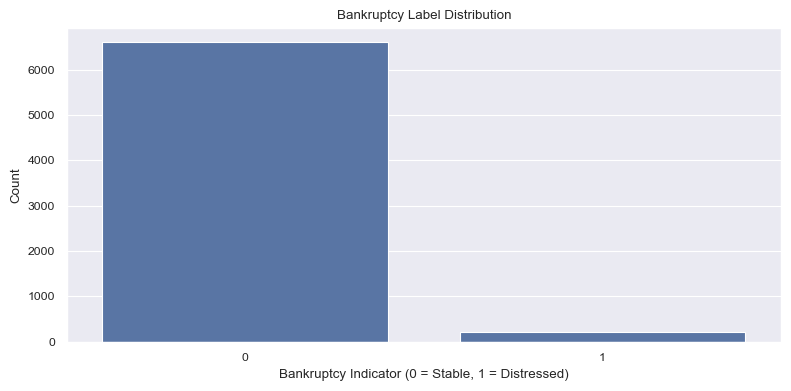

In [6]:
# ------------------------------
# Basic EDA – Target Distribution
# ------------------------------
target = 'bankrupt'
counts = df[target].value_counts()
ratio = counts / len(df) * 100

print(counts)
print('-' * 40)
print(f"Financially stable  (0): {ratio.get(0, 0):.2f}%")
print(f"Financially unstable (1): {ratio.get(1, 0):.2f}%")

# Plot class distribution
sns.set_theme(context='paper')
plt.figure(figsize=(8, 4))
sns.countplot(x=target, data=df)
plt.title('Bankruptcy Label Distribution')
plt.xlabel('Bankruptcy Indicator (0 = Stable, 1 = Distressed)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "target_distribution.png"), dpi=200)
plt.show()
plt.close()

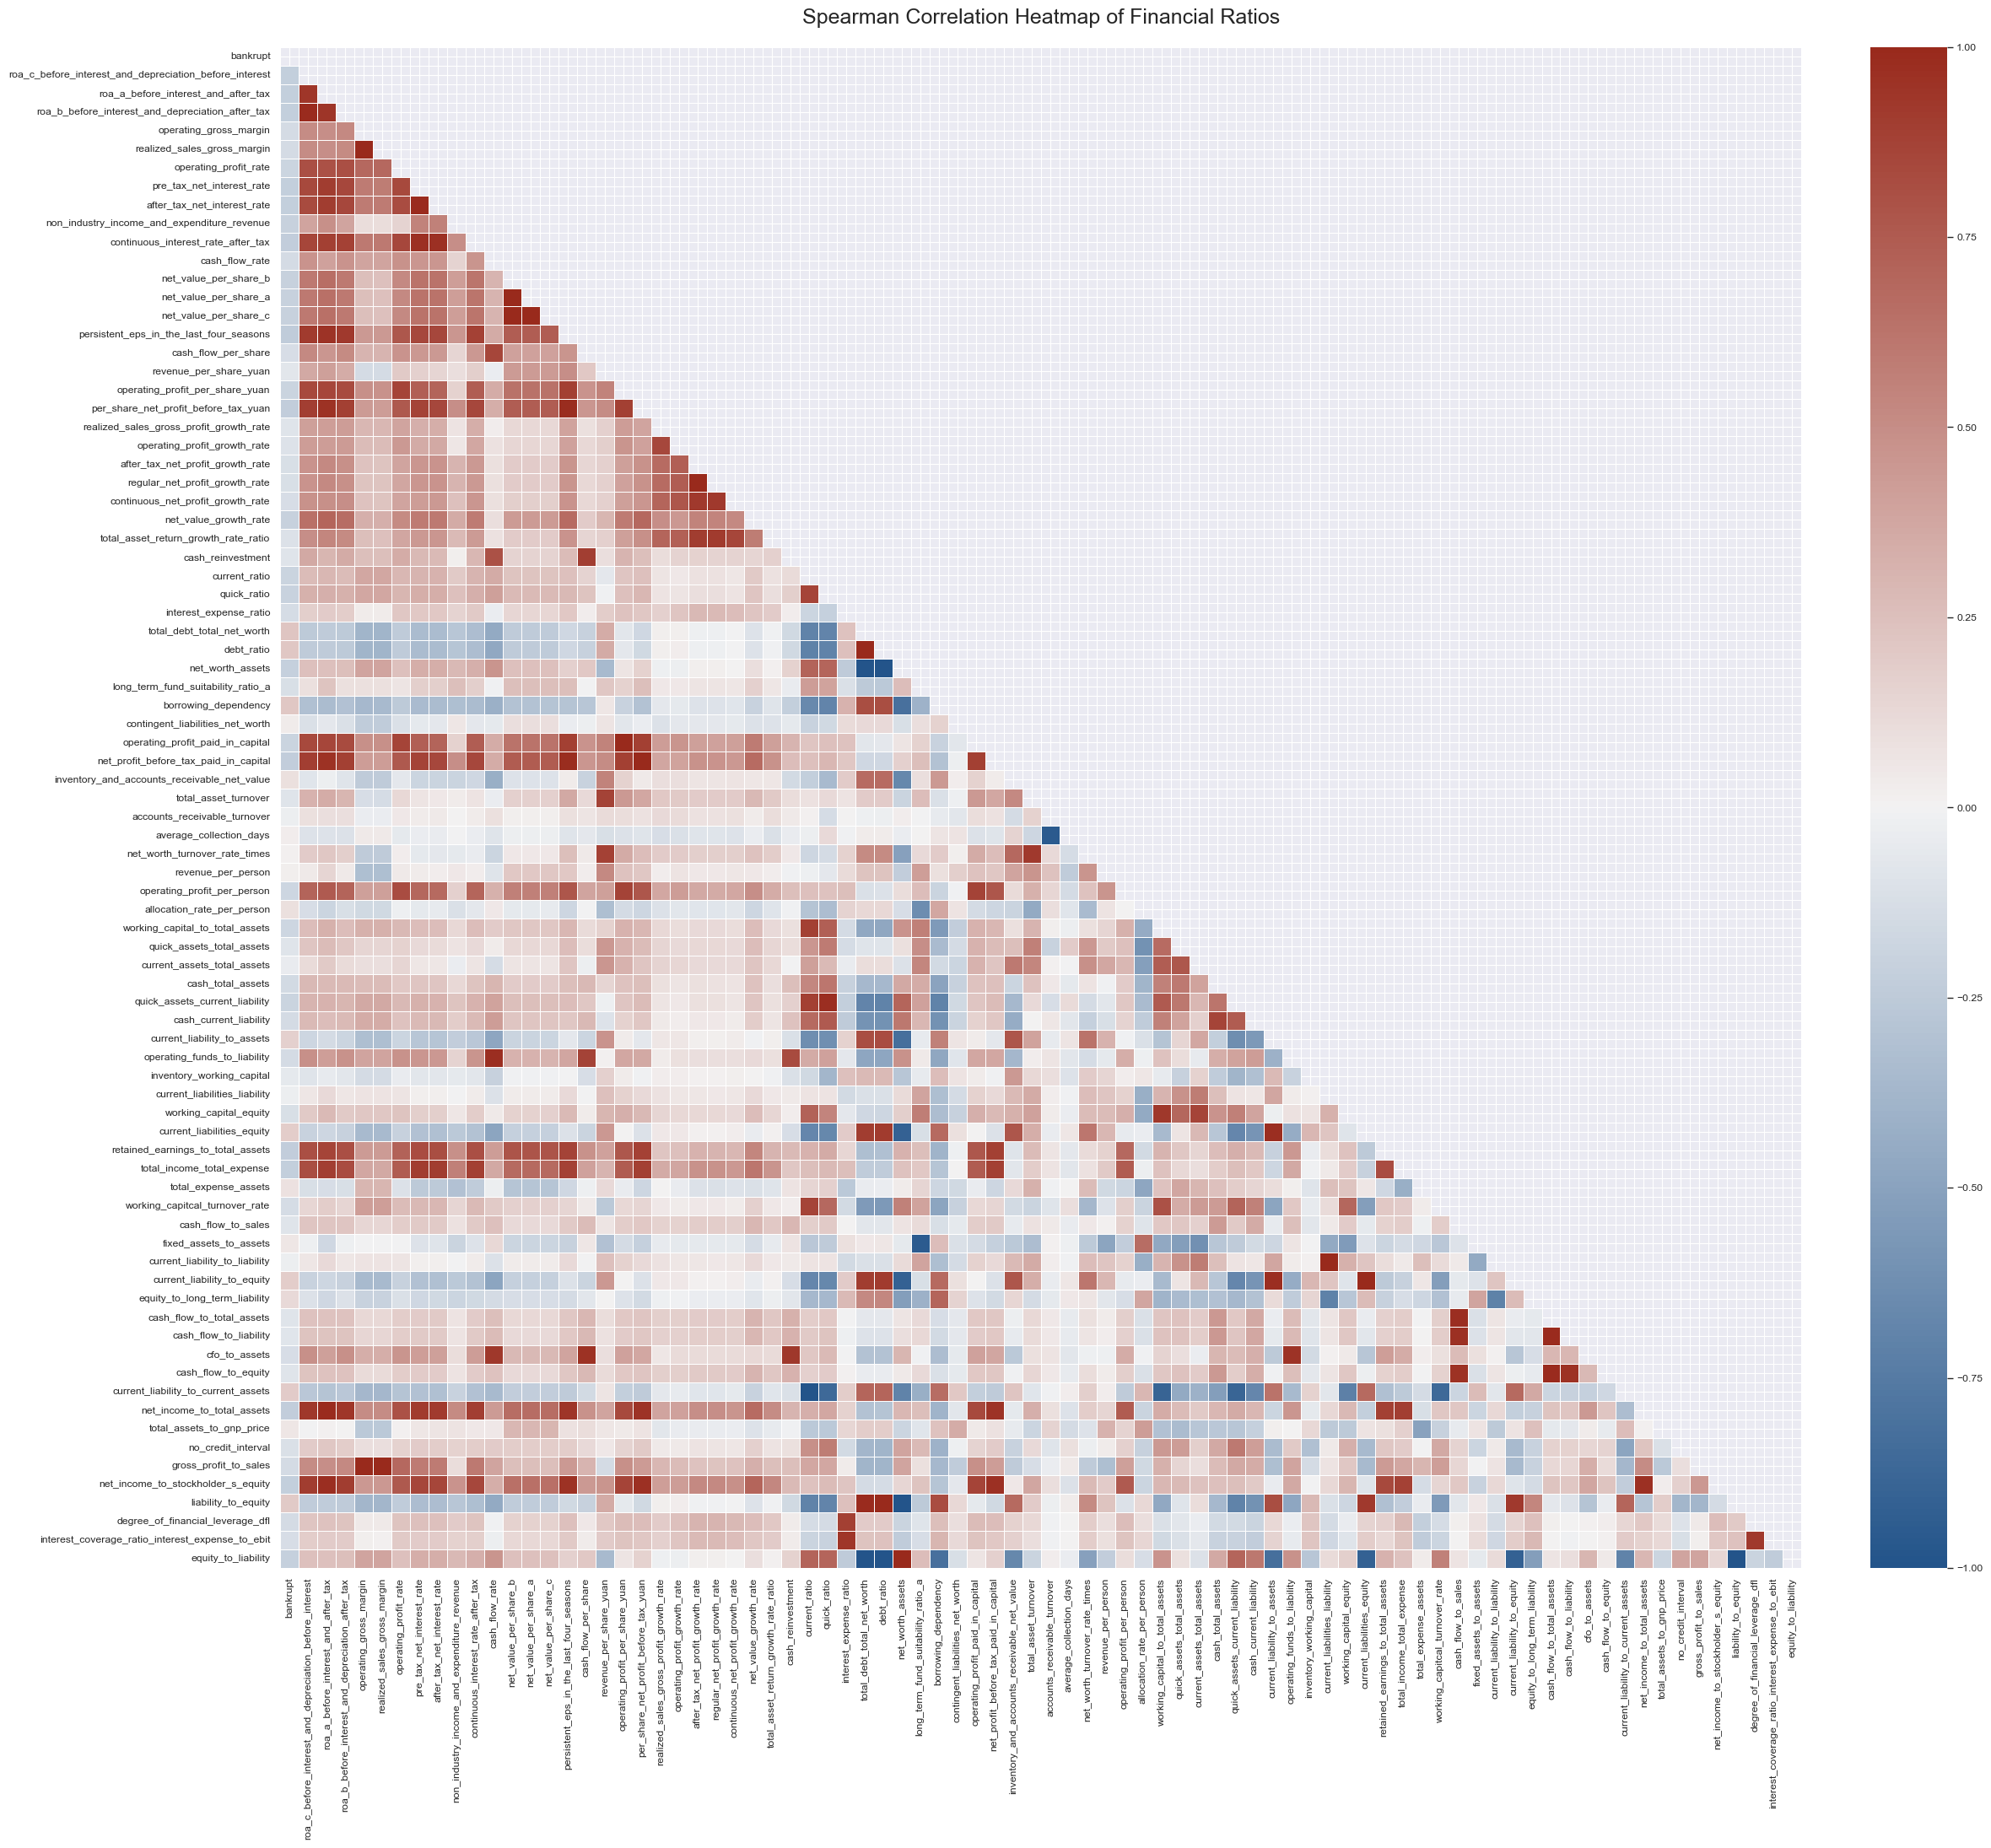

In [7]:
# Correlation Matrix (Spearman) Visualization

corr_matrix = df.corr(method='spearman')

fig, ax = plt.subplots(figsize=(28, 22))
upper_triangle = np.triu(np.ones(corr_matrix.shape, dtype=bool))

palette = sns.diverging_palette(250, 15, s=85, l=35, as_cmap=True)

sns.heatmap(
    corr_matrix,
    mask=upper_triangle,
    cmap=palette,
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=0.4,
    cbar_kws={"fraction": 0.045, "pad": 0.03}
)

ax.set_title("Spearman Correlation Heatmap of Financial Ratios", fontsize=18, pad=20)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "correlation_heatmap.png"), dpi=200)
plt.show()
plt.close()

Conclusion: The Spearman correlation heatmap visually confirms the presence of extensive multicollinearity within the dataset, as evidenced by large, contiguous blocks of ratios displaying strong positive (dark red) and negative (dark blue) correlations. This high degree of inter-correlation demonstrates significant redundancy among the financial features.

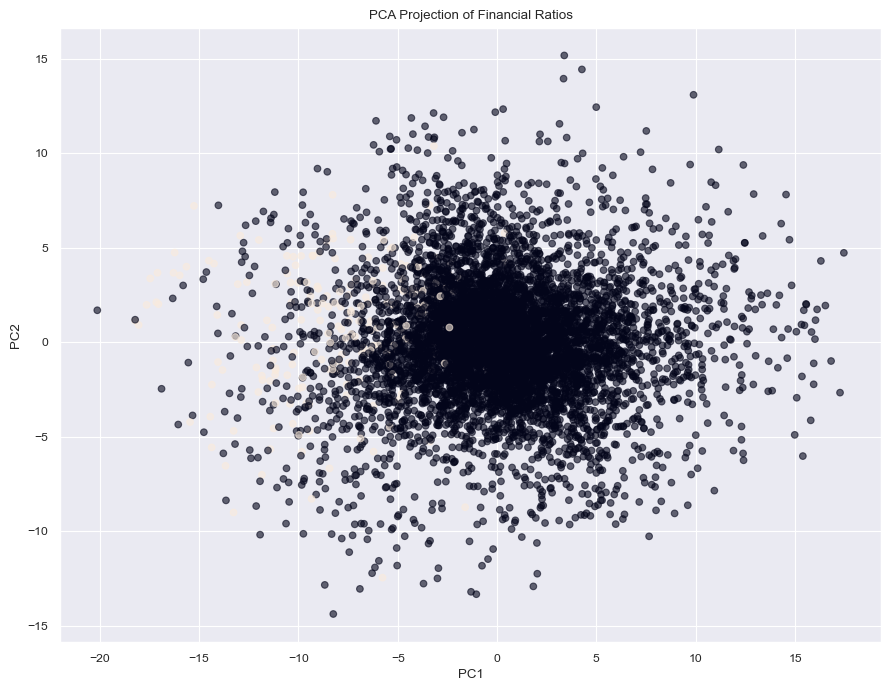

In [8]:
# PCA: Visualizing the structure of financial ratios in lower dimensions

# Separate features and target
X = df.drop(columns=['bankrupt'])
y = df['bankrupt']

# Standardize the features so that each ratio contributes equally
scaled = StandardScaler().fit_transform(X)

# Apply PCA to reduce all financial ratios to two principal components (PC1, PC2)
# PC1 captures the direction of greatest variance in the data,
# PC2 captures the second-most variation, orthogonal to PC1.
pca = PCA(n_components=2).fit_transform(scaled)

# Scatter plot of the transformed data points
# Each point represents a company, positioned by its financial profile in 2D space.
# Colors indicate bankruptcy status (0 = healthy, 1 = bankrupt).
plt.figure(figsize=(9,7))
plt.scatter(pca[:,0], pca[:,1], c=y, alpha=0.6)
plt.title('PCA Projection of Financial Ratios')
plt.xlabel('PC1')  # Higher separation along this axis reflects major financial condition differences
plt.ylabel('PC2')  # Represents secondary patterns not aligned with PC1
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "pca_projection.png"), dpi=200)
plt.show()
plt.close()


Conclusion: The PCA scatter plot demonstrates that high multicollinearity among financial ratios results in a single dense cluster, rendering linear principal components ineffective at distinguishing bankrupt from non-bankrupt firms.

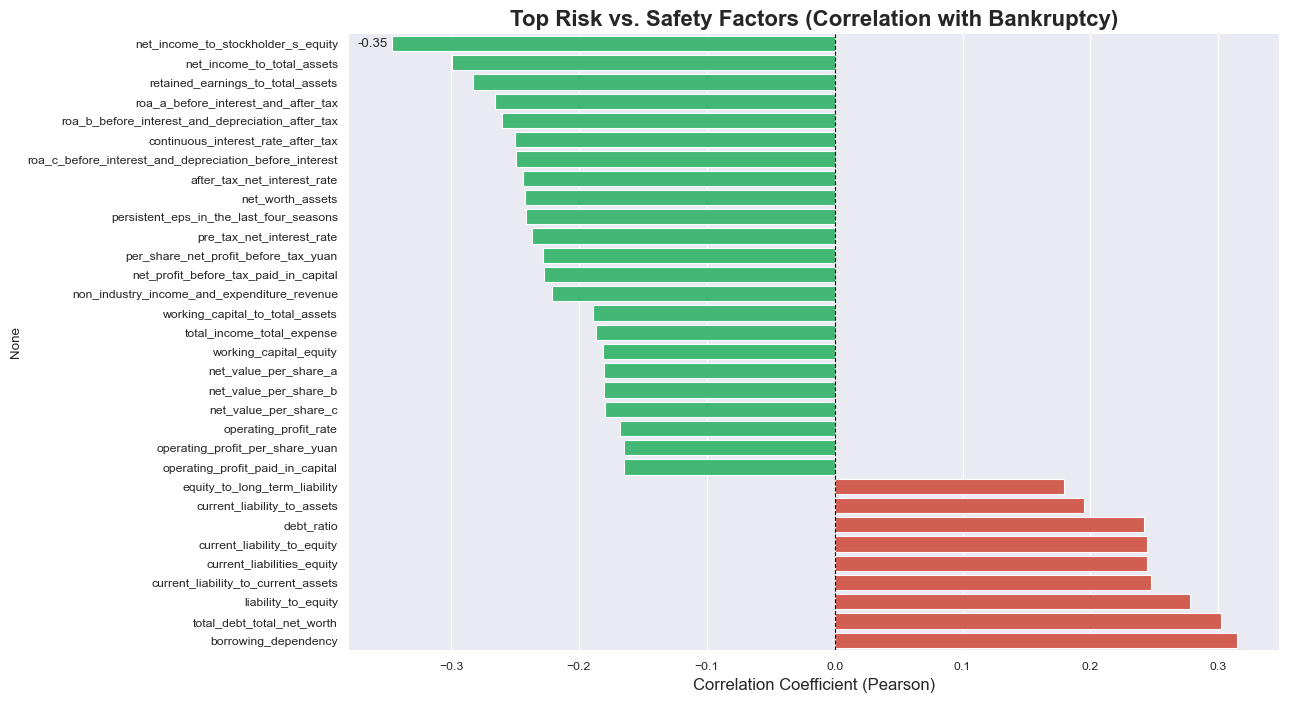

In [9]:
# Calculate correlations with bankrupt
corr = df.corr()['bankrupt'].drop('bankrupt')

# Features positively associated with bankruptcy risk
top_risk = corr[corr >= CORRELATION_THRESH].sort_values(ascending=False)

# Features negatively associated (protective / healthy firms)
top_safe = corr[corr <= -CORRELATION_THRESH].sort_values(ascending=True)

# Combine and sort for plotting
top_corr = pd.concat([top_risk, top_safe]).sort_values()

# Plot
plt.figure(figsize=(12, 8))
colors = ['#e74c3c' if x > 0 else '#2ecc71' for x in top_corr.values]

ax = sns.barplot(x=top_corr.values, y=top_corr.index, palette=colors)

# Clean up the chart
ax.bar_label(ax.containers[0], fmt='%.2f', padding=3)
plt.title("Top Risk vs. Safety Factors (Correlation with Bankruptcy)", fontsize=16, weight='bold')
plt.xlabel("Correlation Coefficient (Pearson)", fontsize=12)
plt.axvline(0, color='black', linewidth=0.8, linestyle='--') # Zero line
sns.despine(left=True, bottom=True)
plt.savefig(os.path.join(OUTPUT_DIR, "risk_safe_factors.png"), dpi=200)
plt.show()
plt.close()


## Modeling and Evaluation

First, we prepare the train/test data for the baseline model

In [10]:
# Train test split
y = df["bankrupt"]
X = df.drop(columns=["bankrupt"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

**Baseline 1: Naive baseline**

In [11]:
# Always predict non-bankrupt
y_pred = [0] * len(y_test)

print("\nClassification Report (F1-optimized threshold):")
print(classification_report(y_test, y_pred, digits=3))


Classification Report (F1-optimized threshold):
              precision    recall  f1-score   support

           0      0.968     1.000     0.984      1980
           1      0.000     0.000     0.000        66

    accuracy                          0.968      2046
   macro avg      0.484     0.500     0.492      2046
weighted avg      0.937     0.968     0.952      2046



**Baseline 2: Insight based forecasting**

In [12]:
# Ratios commonly chosen from literature
DOMAIN_FEATURES = [
    "current_ratio",
    "quick_ratio",
    "working_capital_to_total_assets",
    "retained_earnings_to_total_assets",
    "ebit_to_total_assets",
    "market_value_of_equity_to_total_liabilities",
    "sales_to_total_assets",
    "cash_flow_to_liability",
    "cash_flow_to_assets",
    "net_income_to_total_assets",
    "liability_to_equity",
]

selected_features = [c for c in DOMAIN_FEATURES if c in df.columns]

# Using new selected features
X_train, X_test, y_train, y_test = train_test_split(
    df[selected_features], y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)


=== Random Forest Metrics ===
ROC-AUC: 0.9107361493725131
PR-AUC: 0.34331804546127875
              precision    recall  f1-score   support

           0      0.971     0.997     0.984      1980
           1      0.500     0.091     0.154        66

    accuracy                          0.968      2046
   macro avg      0.735     0.544     0.569      2046
weighted avg      0.955     0.968     0.957      2046



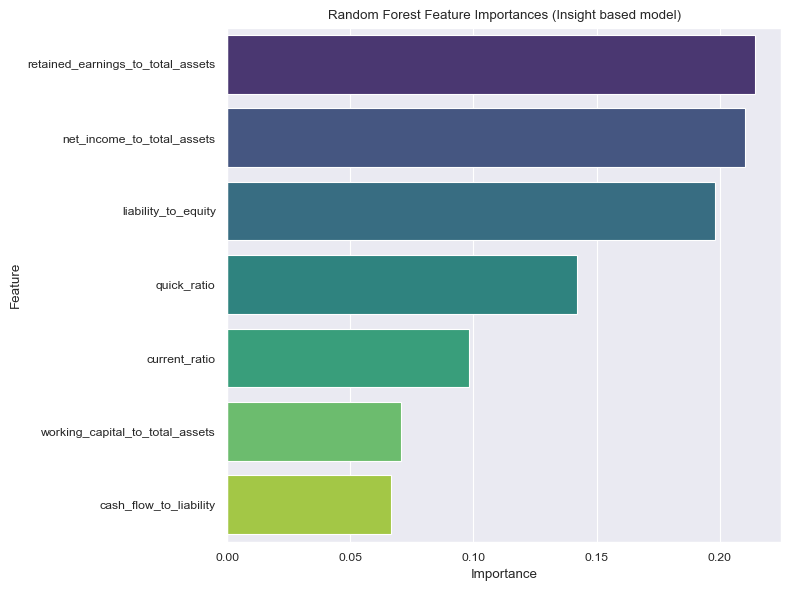

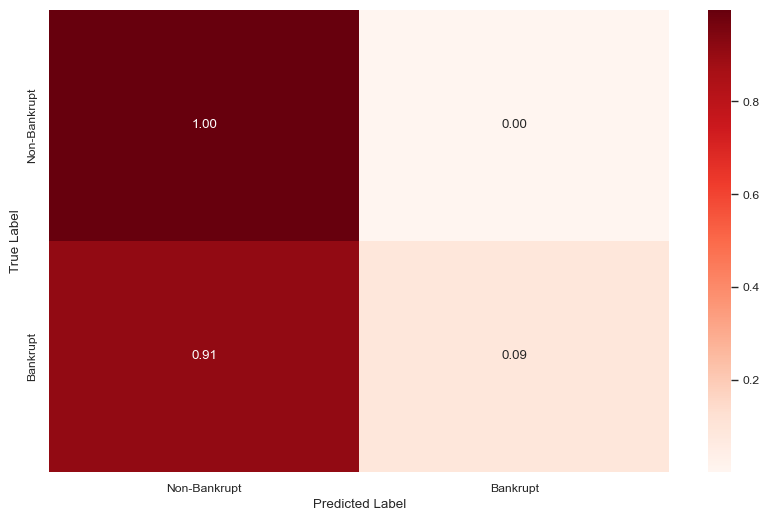

In [13]:
# ------------------------------
# Random Forest
# ------------------------------
rf = RandomForestClassifier(
    n_estimators=800,
    random_state=RANDOM_STATE,
    class_weight="balanced",
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("\n=== Random Forest Metrics ===")
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("PR-AUC:", average_precision_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf, digits=3))

rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=rf_importances.values, y=rf_importances.index, palette="viridis")
plt.title("Random Forest Feature Importances (Insight based model)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "insight_feature_importances.png"), dpi=200)
plt.show()
plt.close()

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Normalize by row (divide each row by the sum of that row)
cm_rates = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display normalized confusion matrix
labels = ['Non-Bankrupt', 'Bankrupt']

plt.figure(figsize=(10,6))
sns.heatmap(cm_rates, annot=True, fmt=".2f", cmap="Reds", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(OUTPUT_DIR, "insight_confusion_matrix.png"), dpi=200)
plt.show()
plt.close()

**Improved Model**

Feature Engineering

We chose to select features that have highest absolute correlation with bankrupt, plus manually selected features if they were not already in the feature columns.

In [14]:
# Extract selected feature names from the correlation Series
corr_features = set(top_corr.index)

# Add domain-important ones only if present in df and not already selected
manual_additions = [f for f in DOMAIN_FEATURES if f in df.columns and f not in corr_features]

# Final candidate list
candidate_features = sorted(corr_features.union(manual_additions))

print("Correlation-selected features:", len(corr_features))
print("Manually added domain features:", manual_additions)
print("Total candidate features:", len(candidate_features))

Correlation-selected features: 32
Manually added domain features: ['current_ratio', 'quick_ratio', 'cash_flow_to_liability']
Total candidate features: 35


By applying VIF pruning, we remove features that convey overlapping information, ensuring that the remaining predictors are not redundant and reducing multicollinearity before model training.

In [15]:
# ------------------------------
# VIF-based iterative pruning
# ------------------------------
from utils.vif import reduce_vif_ratio

X_reduced, vif_drops = reduce_vif_ratio(df[candidate_features], ratio=VIF_THRESHOLD)

print("\nFinal feature set after VIF reduction:")
for c in X_reduced.columns:
    print("  -", c)

C:\ProgramData\anaconda3\envs\Bankruptcy_env_2\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped 'current_liabilities_equity' with VIF=inf (> 359.68 = 5×median).
Dropped 'net_worth_assets' with VIF=87698743.52 (> 331.39 = 5×median).
Dropped 'after_tax_net_interest_rate' with VIF=785584846.10 (> 57405.51 = 5×median).
Dropped 'continuous_interest_rate_after_tax' with VIF=115827493.65 (> 56815.14 = 5×median).
Dropped 'pre_tax_net_interest_rate' with VIF=39171040.03 (> 55360.53 = 5×median).
Dropped 'operating_profit_rate' with VIF=3417252.33 (> 46375.16 = 5×median).
Dropped 'non_industry_income_and_expenditure_revenue' with VIF=911590.37 (> 37333.64 = 5×median).
Dropped 'net_income_to_stockholder_s_equity' with VIF=492186.27 (> 36461.38 = 5×median).
Dropped 'current_liability_to_equity' with VIF=414416.96 (> 35529.39 = 5×median).
Dropped 'net_value_per_share_a' with VIF=229671.83 (> 33983.84 = 5×median).
Dropped 'liability_to_equity' with VIF=67227.51 (> 32100.56 = 5×median).
Dropped 'net_value_per_share_b' with VIF=56853.17 (> 27985.47 = 5×median).
Dropped 'working_capital_eq

In [16]:
# Selected features
X_reduced.columns.tolist()

['cash_flow_to_liability',
 'current_liability_to_assets',
 'current_liability_to_current_assets',
 'current_ratio',
 'debt_ratio',
 'net_value_per_share_c',
 'operating_profit_per_share_yuan',
 'per_share_net_profit_before_tax_yuan',
 'quick_ratio',
 'roa_c_before_interest_and_depreciation_before_interest',
 'total_debt_total_net_worth',
 'total_income_total_expense',
 'working_capital_to_total_assets']

In [17]:
# ============================================================
# Train/Valid/Test Split
# ============================================================
X_train, X_temp, y_train, y_temp = train_test_split(
    X_reduced, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

print("\nTrain/Valid/Test shapes:")
print("X_train:", X_train.shape, "   X_val:", X_val.shape, "   X_test:", X_test.shape)


Train/Valid/Test shapes:
X_train: (4773, 13)    X_val: (1023, 13)    X_test: (1023, 13)


Augment negative samples to mitigate skewness

In [18]:
# ============================================================
# Negative Sample Augmentation (Hard Negatives)
# ============================================================
from utils.feature_engineering import augment_negative_samples

print("\nAugmenting negative samples...")
X_train_aug, y_train_aug = augment_negative_samples(
    X_train, y_train,
    factor=1.0,        # create 100% more hard negatives
    noise_scale=0.1,  # noise intensity
    random_state=RANDOM_STATE
)

print("After negative augmentation:", np.bincount(y_train_aug))


Augmenting negative samples...
After negative augmentation: [9238  154]


SMOTE oversampling

In [19]:
# ============================================================
# SMOTE Oversampling for Positive Class (bankrupt=1)
# ============================================================

print("\nApplying SMOTE...")
smote = SMOTE(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = smote.fit_resample(X_train_aug, y_train_aug)

print("After SMOTE balancing:", np.bincount(y_train_bal))



Applying SMOTE...
After SMOTE balancing: [9238 9238]



=== Improved Model Metrics ===
ROC-AUC: 0.8936945209672482
PR-AUC: 0.3871136197222027
              precision    recall  f1-score   support

           0      0.986     0.969     0.977       990
           1      0.380     0.576     0.458        33

    accuracy                          0.956      1023
   macro avg      0.683     0.772     0.717      1023
weighted avg      0.966     0.956     0.960      1023



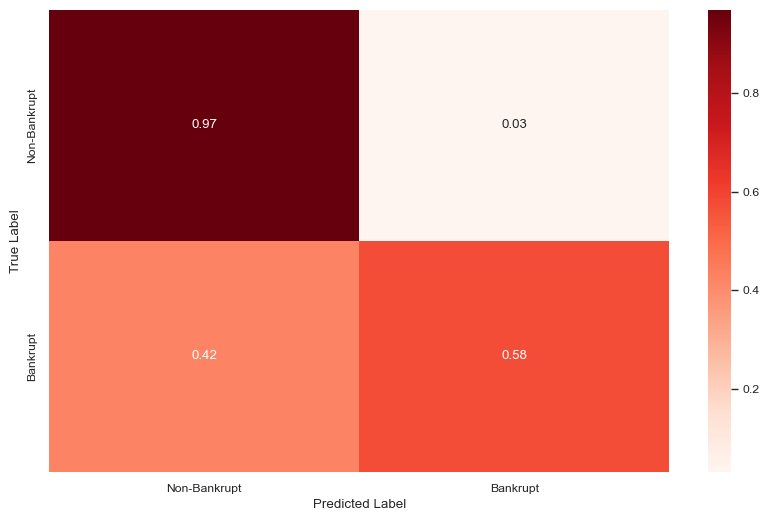

In [28]:
# ============================================================
# Random Forest With SHAP
# ============================================================
model_shap = RandomForestClassifier(
    n_estimators=800,
    max_depth=6,
    random_state=RANDOM_STATE,
    class_weight="balanced",
    n_jobs=-1
)
model_shap.fit(X_train, y_train)

# ============================================================
# Threshold Tuning – maximize F1 for class 1 on validation set
# ============================================================
from utils.tune_threshold import tune_threshold

best_thr = tune_threshold(model_shap, X_val, y_val)

# Test on test set
y_proba_test =  model_shap.predict_proba(X_test)[:, 1]
y_pred_best = (y_proba_test >= best_thr).astype(int)

print("\n=== Improved Model Metrics ===")
print("ROC-AUC:", roc_auc_score(y_test, y_proba_test))
print("PR-AUC:", average_precision_score(y_test, y_proba_test))
print(classification_report(y_test, y_pred_best, digits=3))


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

# Normalize by row (divide each row by the sum of that row)
cm_rates = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display normalized confusion matrix
labels = ['Non-Bankrupt', 'Bankrupt']

plt.figure(figsize=(10,6))
sns.heatmap(cm_rates, annot=True, fmt=".2f", cmap="Reds", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(OUTPUT_DIR, "improved_confusion_matrix.png"), dpi=200)
plt.show()
plt.close()


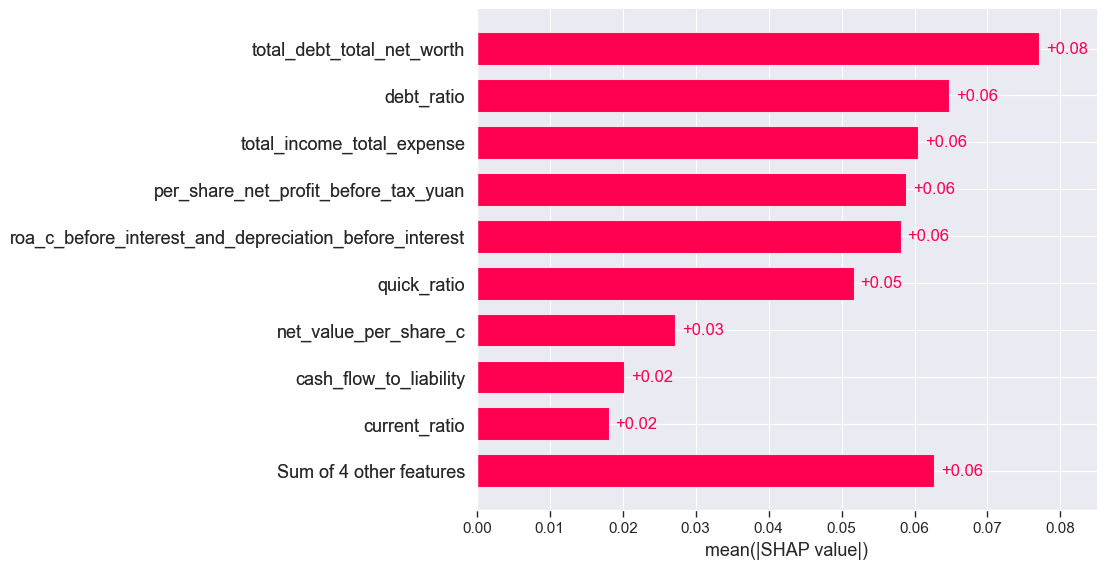

<Figure size 640x480 with 0 Axes>

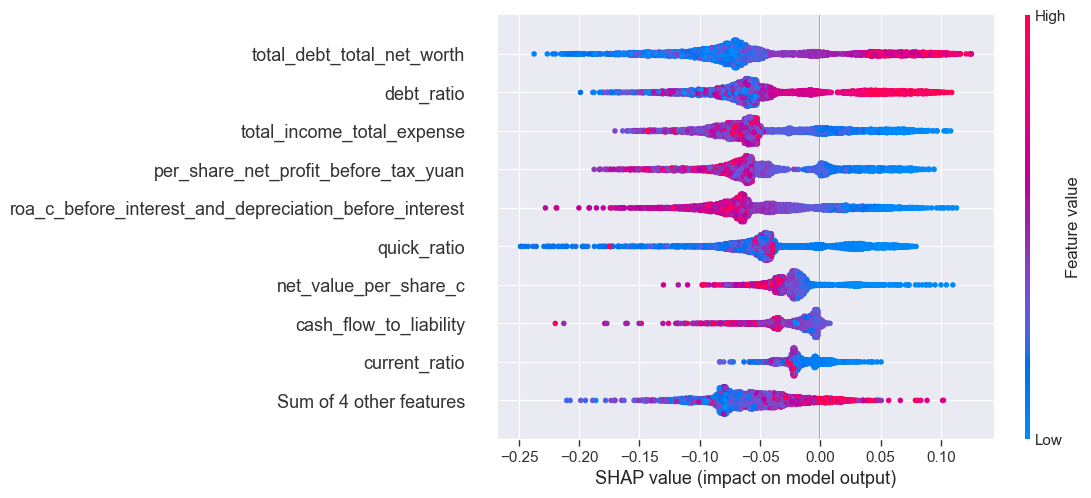

<Figure size 640x480 with 0 Axes>

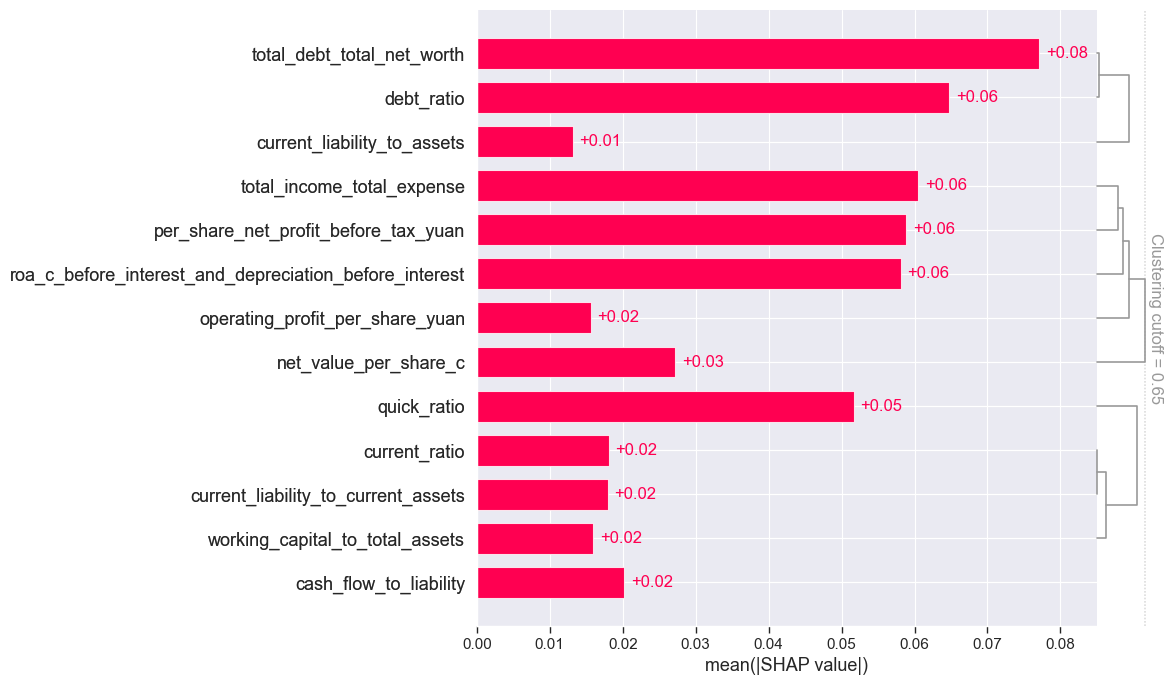

<Figure size 640x480 with 0 Axes>

In [21]:
# Fitting SHAP to RF classifier
explainer = shap.TreeExplainer(model_shap)
shap_values = explainer.shap_values(X_train)

sv = shap_values[:,:,1]  # Pick the SHAP values for the positive class
sv_plot = sv.reshape(sv.shape[0], sv.shape[1])  # Ensure shape is (n_samples, n_features)
base = explainer.expected_value[1]  # Base value for the positive class

# Build Explanation object (include feature names from X_train)
expl = shap.Explanation(values=sv_plot, base_values=base, data=X_train, feature_names=list(X_train.columns))

# Visualization
shap.plots.bar(expl, max_display=10)
plt.savefig(os.path.join(OUTPUT_DIR, "shap_expl_bar.png"), dpi=200)
plt.show()
plt.close()
shap.plots.beeswarm(expl, max_display=10)
plt.savefig(os.path.join(OUTPUT_DIR, "shap_expl_beeswarm.png"), dpi=200)
plt.show()
plt.close()

clustering = shap.utils.hclust(X_train, y_train)
shap.plots.bar(expl, clustering=clustering, clustering_cutoff=.65, max_display=20)
plt.savefig(os.path.join(OUTPUT_DIR, "shap_clustering.png"), dpi=200)
plt.show()
plt.close()


Using SHAP analysis on the bankrupting class, we can determine the importance ranking of each feature in our current model from the bar plot, which plots each feature's absolute effect on classification. Using the beeswarm plot, we can also see what values are correlated with bankrupting vs. succeeding (further to right means the feature pushes classifier to predict bankruptcy).

Adding clustering to the analysis, we can also see how the features correlate with each other. This gives us a reduced feature set by grouping the impact of correlated features.

Selected SHAP features: ['debt_ratio', 'per_share_net_profit_before_tax_yuan', 'quick_ratio', 'roa_c_before_interest_and_depreciation_before_interest', 'total_debt_total_net_worth', 'total_income_total_expense']

=== Improved Model Metrics ===
ROC-AUC: 0.8956228956228957
PR-AUC: 0.3604469103473047
              precision    recall  f1-score   support

           0      0.986     0.955     0.970       990
           1      0.308     0.606     0.408        33

    accuracy                          0.943      1023
   macro avg      0.647     0.780     0.689      1023
weighted avg      0.965     0.943     0.952      1023



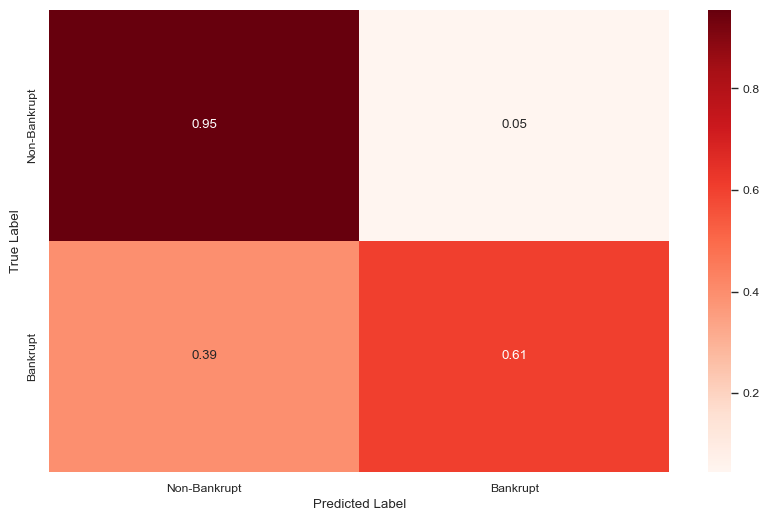

In [29]:
# shap_values is (n_samples, n_features) for the positive class
mean_abs_shap = np.abs(sv).mean(axis=0)
mean_abs_shap = pd.Series(mean_abs_shap, index=X_train.columns)

# Select features above threshold
threshold = 0.05
selected_features = mean_abs_shap[mean_abs_shap >= threshold].index.tolist()

print("Selected SHAP features:", selected_features)

# Define new SHAP-reduced dataset

X_reduced_shap = X[selected_features]

X_train_shap, X_temp_shap, y_train_shap, y_temp_shap = train_test_split(
    X_reduced_shap, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

X_val_shap, X_test_shap, y_val_shap, y_test_shap = train_test_split(
    X_temp_shap, y_temp_shap,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=y_temp_shap
)

model = RandomForestClassifier(
    n_estimators=800,
    max_depth=6,
    random_state=RANDOM_STATE,
    class_weight="balanced",
    n_jobs=-1
)
model.fit(X_train_shap, y_train_shap)

# ============================================================
# Threshold Tuning – maximize F1 for class 1 on validation set
# ============================================================
from utils.tune_threshold import tune_threshold

best_thr = tune_threshold(model, X_val_shap, y_val_shap)

# Test on test set
y_proba_test =  model.predict_proba(X_test_shap)[:, 1]
y_pred_best = (y_proba_test >= best_thr).astype(int)

# Hard class predictions (0 or 1)
y_pred_test = model.predict(X_test_shap)

# Probability predictions -- take probability of class 1 (positive class)
y_proba_test = model.predict_proba(X_test_shap)[:, 1]

# === METRICS ===
print("\n=== Improved Model Metrics ===")
print("ROC-AUC:", roc_auc_score(y_test_shap, y_proba_test))
print("PR-AUC:", average_precision_score(y_test_shap, y_proba_test))
print(classification_report(y_test_shap, y_pred_test, digits=3))

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test_shap, y_pred_test)

# Normalize by rows
cm_rates = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = ['Non-Bankrupt', 'Bankrupt']

plt.figure(figsize=(10,6))
sns.heatmap(cm_rates, annot=True, fmt=".2f", cmap="Reds",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(OUTPUT_DIR, "shap_features_confusion_matrix.png"), dpi=200)
plt.show()
plt.close()


Training a new model on just the most relevant features post-clustering (>=0.05 mean Shapley value) has only a slight reduction in precision and F1 score, while increasing recall on only 6 of the 13 features from the original dataset after VIF pruning.

We can use these particular metrics further downstream using monitoring rules and thresholds on these 6 particular features instead of the larger 13 or full ~90-dimensional data. We could even have users imput these values and return bankrupt/non-bankrupt predictions and warnings if they are close to the threshold.